In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from coffea import util
from coffea.processor import accumulate
import os
import re
import pandas as pd
import hist
import matplotlib as mpl
import mplhep
import sys

sys.path.append("/uscms/home/kyungmip/nobackup/CMSSW_10_6_26/src/iDMe/python_analysis/analysisTools/")
import plotTools as ptools

In [130]:
plt.style.use(mplhep.style.ROOT)
#mplhep.cms.label('', data=False, year=2018)

In [2]:
prefix = './coffea/'
suffix = '_hist_cut8to11'

# Signal
f_sig = "signal_v2_2018_aEM"
sig_histo = util.load(f'{prefix}/{f_sig}{suffix}.coffea')[0]

# Background
bkg_files = {
    "QCD": "bkg_2018_QCD_TuneCP5_PSWeights", # No entry for QCD after OSSF cut
    "Top": "bkg_2018_Top",
    "DY": "bkg_2018_DY",
    "Diboson": "bkg_2018_Diboson",
    "Triboson": "bkg_2018_Triboson",
    "W+jets": "bkg_2018_WJets",
    "Z+jets": "bkg_2018_ZJets",
}

bkg_histos = {}
histograms = []

for b in bkg_files.keys():
    bkg_histos[b] = util.load(f'{prefix}/{bkg_files[b]}{suffix}.coffea')[0]
    histograms = list(bkg_histos[b].keys())

In [33]:
sig_samples = list(sig_histo['cutflow'].keys()) # names of signal sub-process, i.e. mass point, lifetime etc.
print(sig_samples)

['sig_2018_Mchi-55p0_dMchi-10p0_ctau-100', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-10', 'sig_2018_Mchi-55p0_dMchi-10p0_ctau-1', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-100', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-10', 'sig_2018_Mchi-44p0_dMchi-8p0_ctau-100', 'sig_2018_Mchi-52p5_dMchi-5p0_ctau-1', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-100', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-1', 'sig_2018_Mchi-42p0_dMchi-4p0_ctau-1', 'sig_2018_Mchi-33p0_dMchi-6p0_ctau-10', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-1', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-100', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-10', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-100', 'sig_2018_Mchi-22p0_dMchi-4p0_ctau-10', 'sig_2018_Mchi-31p5_dMchi-3p0_ctau-1', 'sig_2018_Mchi-11p0_dMchi-2p0_ctau-100', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-100', 'sig_2018_Mchi-21p0_dMchi-2p0_ctau-1', 'sig_2018_Mchi-11p0_dMchi-2p0_ctau-10', 'sig_2018_Mchi-10p5_dMchi-1p0_ctau-10', 'sig_2018_Mchi-11p0_dMchi-2p0_ctau

In [35]:
cuts = list(sig_histo['cutflow'][sig_samples[0]].keys())
print(cuts)

['all', 'initial', 'cut0', 'cut1', 'cut2', 'cut3', 'cut4', 'cut5', 'cut6', 'cut7', 'cut8', 'cut9', 'cut10', 'cut11']


In [36]:
si = pd.DataFrame.from_dict({s:ptools.signalPoint(s) for s in sig_samples}, orient='index')

print(si)

                                        mchi  dmchi   ctau    m1    m2  delta  \
sig_2018_Mchi-55p0_dMchi-10p0_ctau-100  55.0   10.0  100.0  50.0  60.0    0.2   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-10   55.0   10.0   10.0  50.0  60.0    0.2   
sig_2018_Mchi-55p0_dMchi-10p0_ctau-1    55.0   10.0    1.0  50.0  60.0    0.2   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-100   52.5    5.0  100.0  50.0  55.0    0.1   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-10    52.5    5.0   10.0  50.0  55.0    0.1   
sig_2018_Mchi-44p0_dMchi-8p0_ctau-100   44.0    8.0  100.0  40.0  48.0    0.2   
sig_2018_Mchi-52p5_dMchi-5p0_ctau-1     52.5    5.0    1.0  50.0  55.0    0.1   
sig_2018_Mchi-42p0_dMchi-4p0_ctau-100   42.0    4.0  100.0  40.0  44.0    0.1   
sig_2018_Mchi-42p0_dMchi-4p0_ctau-10    42.0    4.0   10.0  40.0  44.0    0.1   
sig_2018_Mchi-31p5_dMchi-3p0_ctau-100   31.5    3.0  100.0  30.0  33.0    0.1   
sig_2018_Mchi-33p0_dMchi-6p0_ctau-1     33.0    6.0    1.0  30.0  36.0    0.2   
sig_2018_Mchi-42p0_dMchi-4p0

In [45]:
deltas = sorted(list(set(si.delta)))
m1s = sorted(list(set(si.m1)))
all_ctaus = sorted(list(set(si.ctau)))

### Hist objects

In [3]:
# bkg_histos is a dictionary of dictionary
process = 'DY'
var = 'sel_vtx_dR'
print(bkg_histos[process][var])

Hist(
  StrCategory(['bkg_2018_0001', 'bkg_2018_0004', 'bkg_2018_0000'], growth=True, name='samp', label='Sample Name'),
  StrCategory(['nocut', 'cut8', 'cut9', 'cut10'], growth=True, name='cut', label='Cut Applied'),
  Regular(100, 0, 6, name='dr', label='$\\Delta R$'),
  storage=Weight()) # Sum: WeightedSum(value=3188.69, variance=3.05364e+06)


In [4]:
# Access a sub-sample of the sample (or process) 'DY'
bkg_histos[process][var][{'samp': 'bkg_2018_0004'}] 

Hist(
  StrCategory(['nocut', 'cut8', 'cut9', 'cut10'], growth=True, name='cut', label='Cut Applied'),
  Regular(100, 0, 6, name='dr', label='$\\Delta R$'),
  storage=Weight()) # Sum: WeightedSum(value=1702.31, variance=2.89787e+06)

In [5]:
# Entries of the hist
print(bkg_histos[process][var][{'samp': 'bkg_2018_0004'}].sum().value)

1702.3123779296875


In [6]:
# Access all the sub-samples of the sample (or process) 'DY'
bkg_histos[process][var][{'samp': sum}]

Hist(
  StrCategory(['nocut', 'cut8', 'cut9', 'cut10'], growth=True, name='cut', label='Cut Applied'),
  Regular(100, 0, 6, name='dr', label='$\\Delta R$'),
  storage=Weight()) # Sum: WeightedSum(value=3188.69, variance=3.05364e+06)

In [10]:
# Access all the sub-samples of the sample (or process) 'DY'
bkg_histos[process][var][{'samp': sum, 'cut': 'nocut'}]

Hist(Regular(100, 0, 6, name='dr', label='$\\Delta R$'), storage=Weight()) # Sum: WeightedSum(value=2758.17, variance=2.99185e+06)

In [11]:
# Entries
print(bkg_histos[process][var][{'samp': sum}].sum().value)

3188.694610595703


In [12]:
# Access all the sub-samples of the sample (or process) 'DY' at certain cut
bkg_histos[process][var][{'samp': sum, 'cut': 'cut8'}]

Hist(Regular(100, 0, 6, name='dr', label='$\\Delta R$'), storage=Weight()) # Sum: WeightedSum(value=143.509, variance=20594.8)

In [13]:
# Entries at certain cut
print(bkg_histos[process][var][{'samp': sum, 'cut': 'cut8'}].sum().value)

143.5089569091797


### Plot backgrounds

In [16]:
bkg = {}

for h in histograms:
    bkg[h] = {}
    for b in bkg_histos.keys():
        if type(bkg_histos[b][h]) == hist.Hist and bkg_histos[b][h].sum(flow=True).value > 0:
            bkg[h][b] = bkg_histos[b][h][{"samp":sum}]

In [18]:
hname = 'sel_vtx_minDxy'

cut = 'nocut'
rebin = 5j

# sort the histograms by the entries
for b in bkg_histos.keys():
    entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}

sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))
print(sorted_entries)

bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    
nb = len(bkg_stack.keys())
hb = hist.Stack.from_dict(bkg_stack)

{'W+jets': 34261.33985247143, 'Z+jets': 17032.071138250176, 'DY': 3188.694610595703, 'QCD': 2948.0585146844387, 'Top': 1078.5506067462265, 'Diboson': 631.1536145806313, 'Triboson': 8.599148083478212}


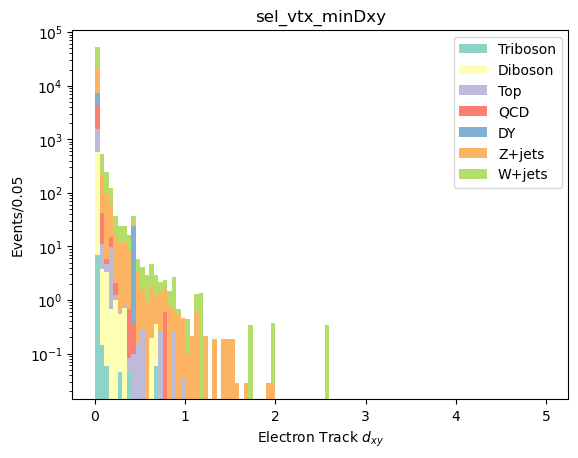

In [31]:
binwidth = hb['W+jets'].axes.widths[0][0]

plt.title(hname)

hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

plt.ylabel(f'Events/{binwidth}')
plt.yscale('log')
plt.legend()

### Plot signal

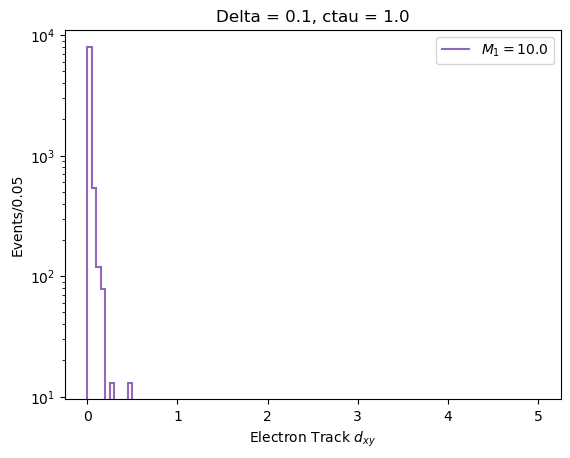

In [58]:
# plot signals
delta = deltas[0]
m1 = m1s[0]
ct = all_ctaus[0]

flow_str = None

plt.title(f'Delta = {delta}, ctau = {ct}')

point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)

binwidth = hb['W+jets'].axes.widths[0][0]

plt.ylabel(f'Events/{binwidth}')
plt.yscale('log')
plt.legend()

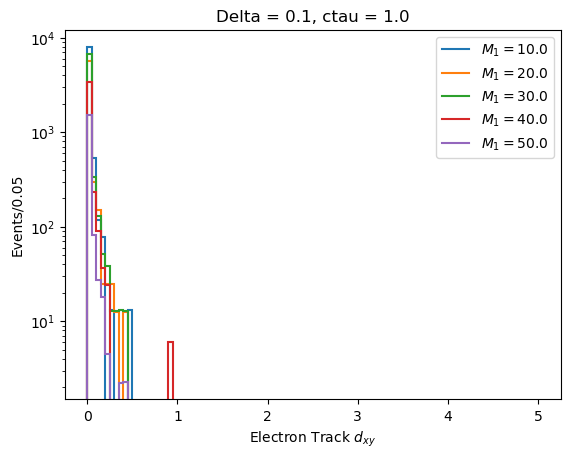

In [59]:
# plot signals overlaid
delta = deltas[0]
ct = all_ctaus[0]

flow_str = None

plt.title(f'Delta = {delta}, ctau = {ct}')

for j, m1 in enumerate(m1s): 
    point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
    hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
    mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)

binwidth = hb['W+jets'].axes.widths[0][0]

plt.ylabel(f'Events/{binwidth}')
plt.yscale('log')
plt.legend()

### Plotting functions

In [148]:
def plot_bkg(hname, cut, rebin=1j, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])
    
    plt.ylabel(f'Events/{binwidth}')
    if doLog:
        plt.yscale('log')
    plt.legend()

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

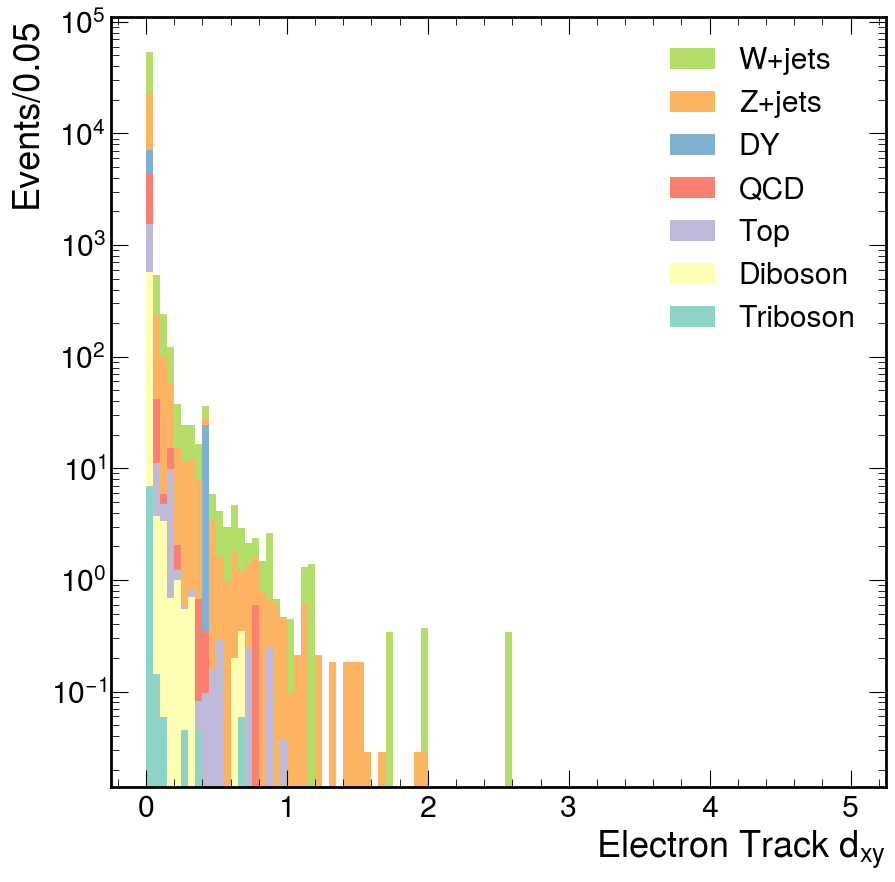

In [149]:
plot_bkg('sel_vtx_minDxy', 'nocut', rebin=5j)

In [150]:
def plot_sig(hname, cut, delta, m1, ct, rebin=1j, flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
    hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
    mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel(f'Events/{binwidth}')
    if doLog:
        plt.yscale('log')
    plt.legend()

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
        
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

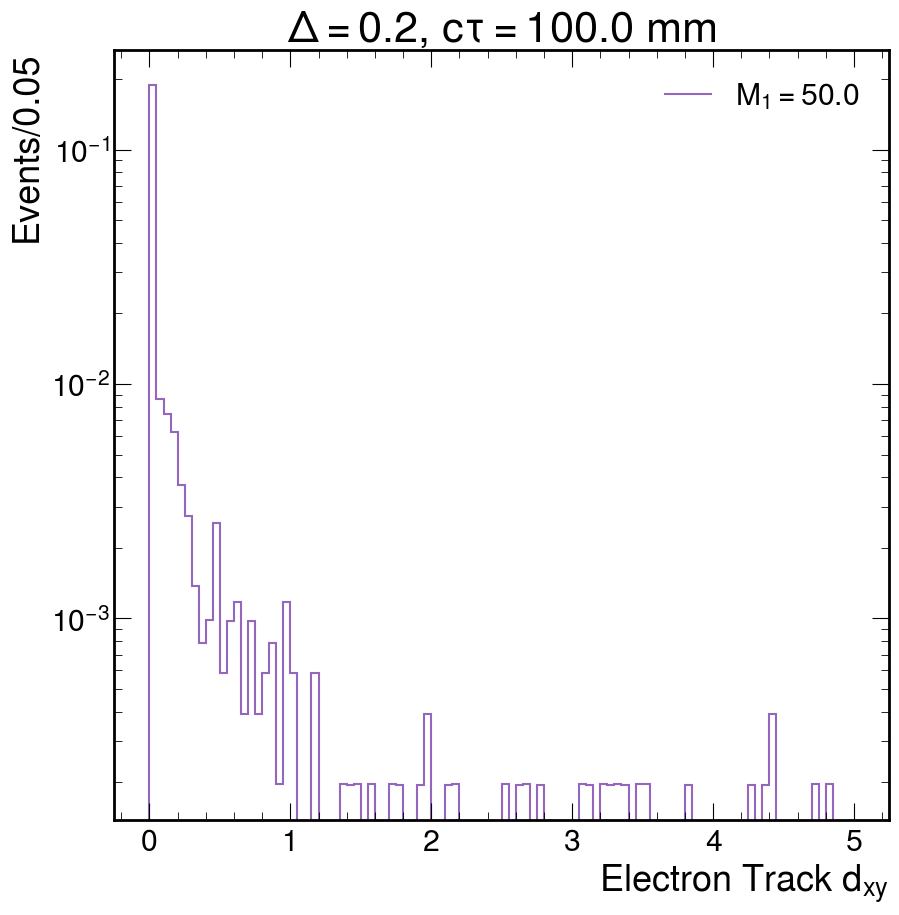

In [151]:
plot_sig('sel_vtx_minDxy', 'nocut', delta, m1, ct, rebin=5j)

In [152]:
def plot_sig_varying_M1(hname, cut, delta, ct, rebin=1j, flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel(f'Events/{binwidth}')
    if doLog:
        plt.yscale('log')
    plt.legend()

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

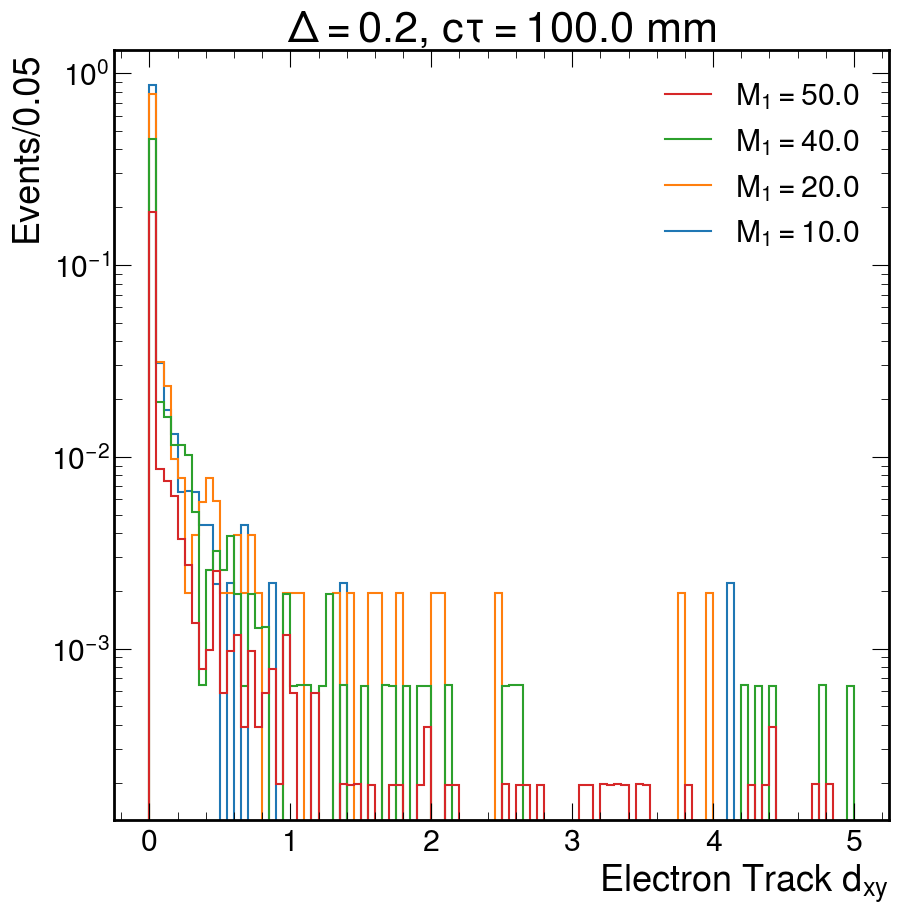

In [153]:
plot_sig_varying_M1('sel_vtx_minDxy', 'nocut', delta, ct, rebin=5j)

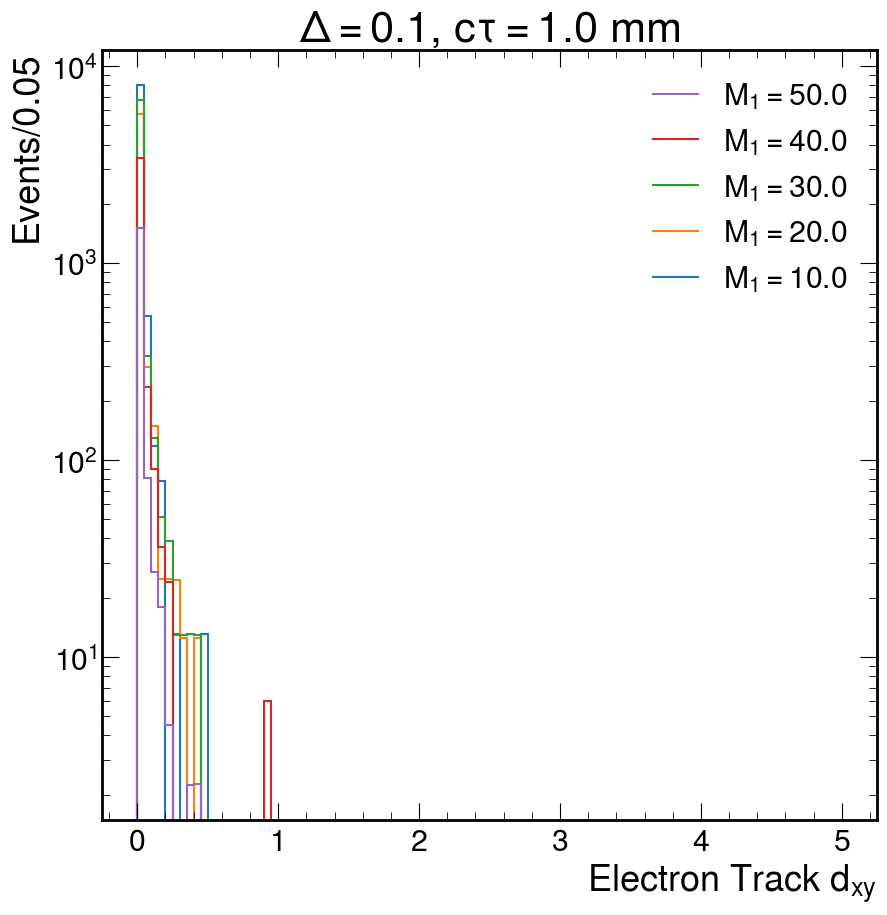

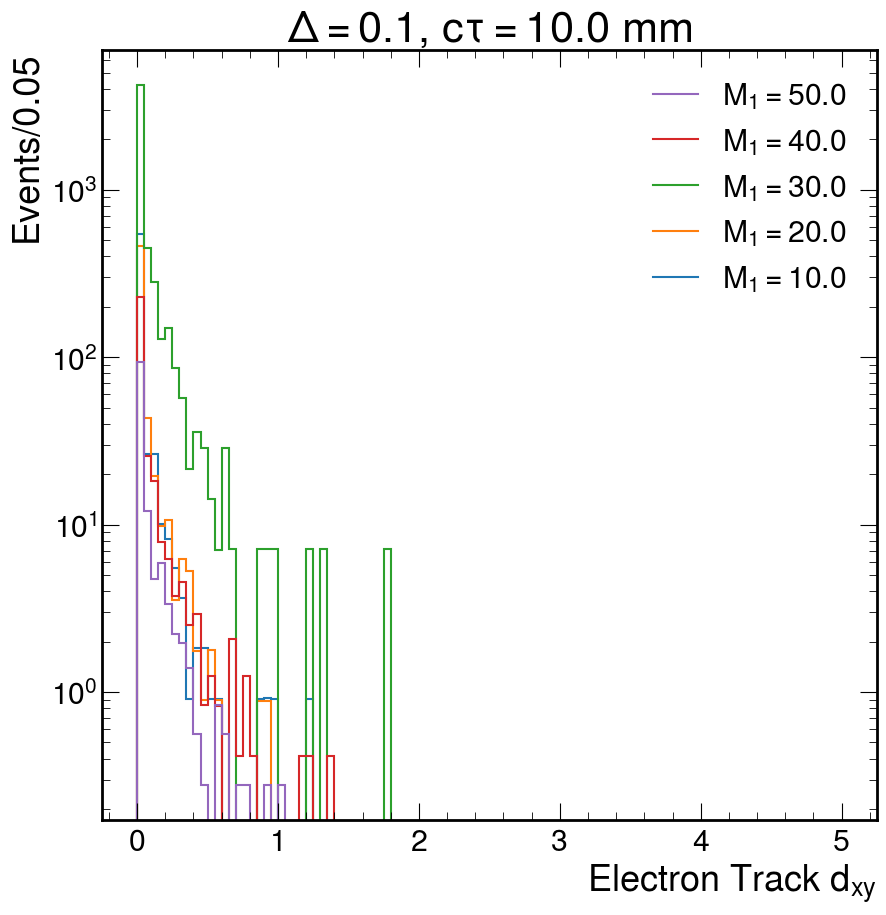

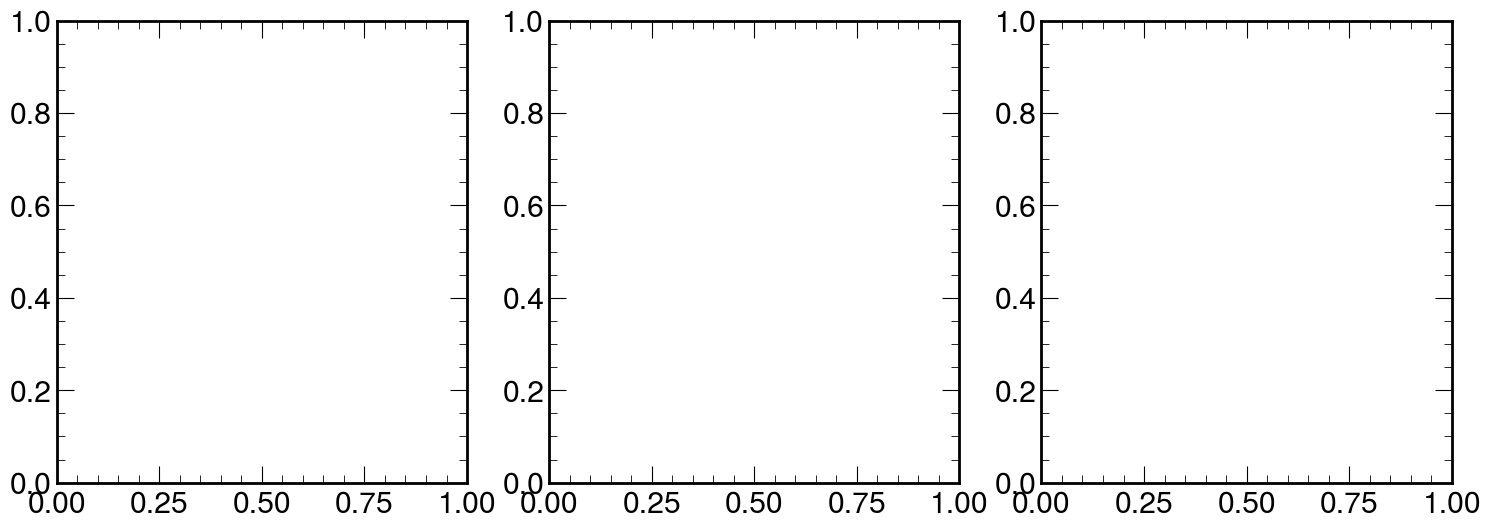

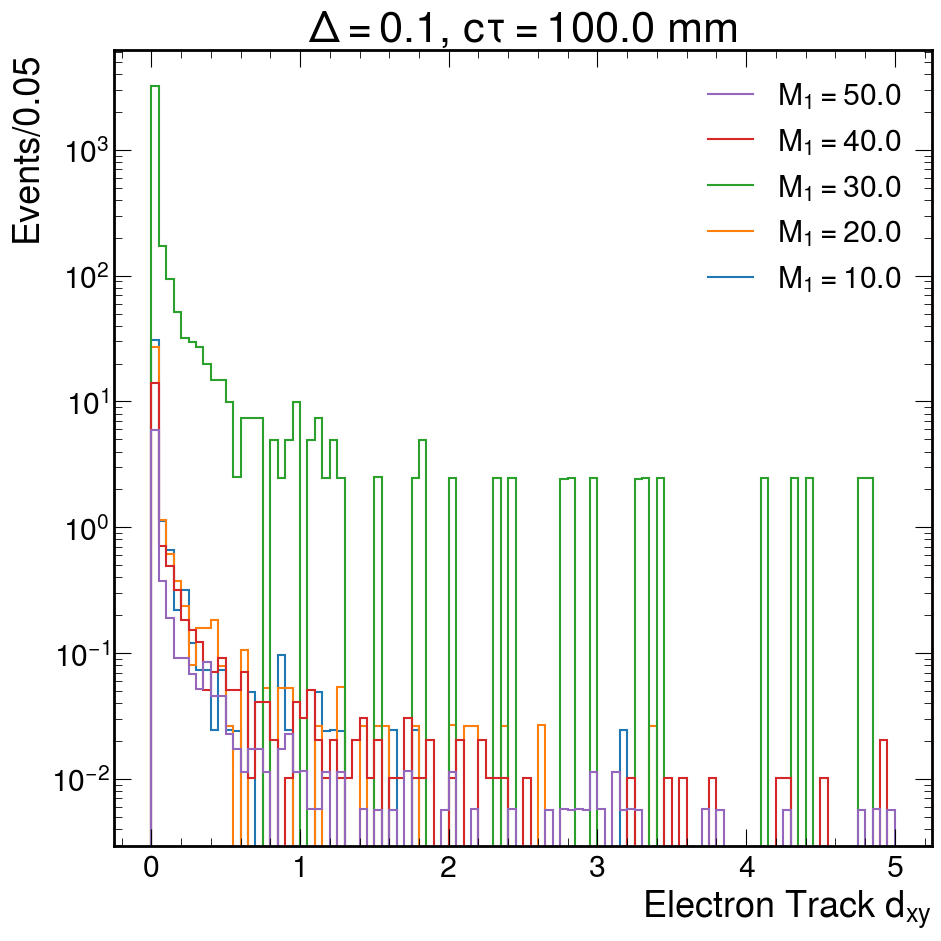

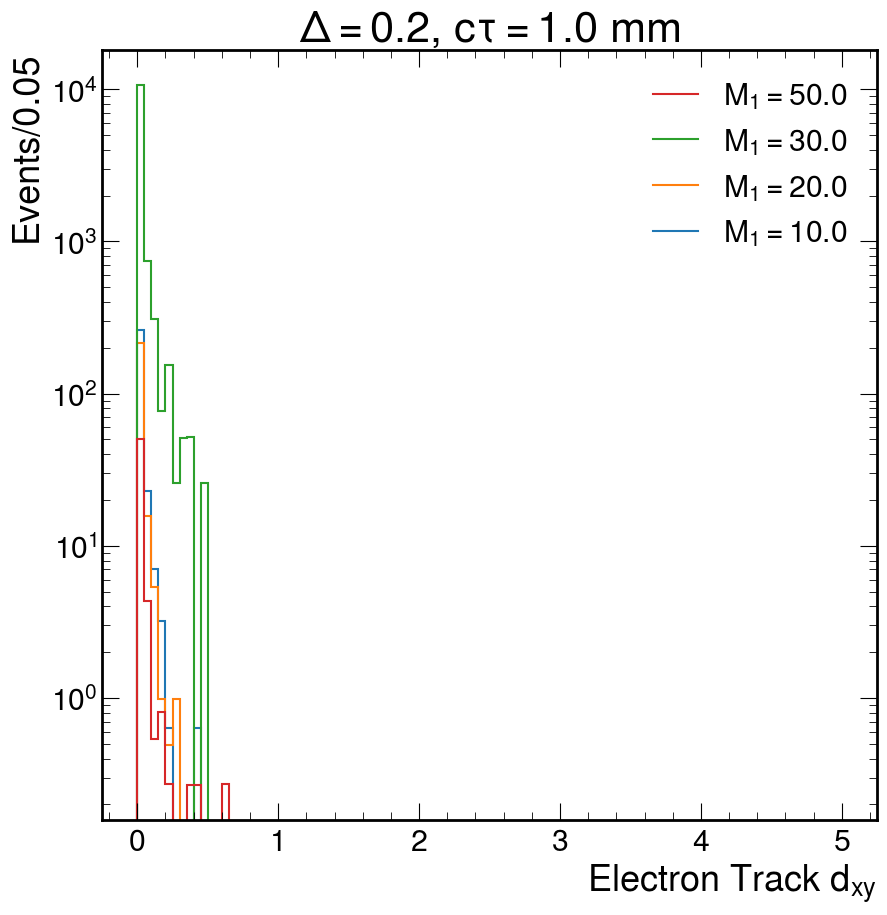

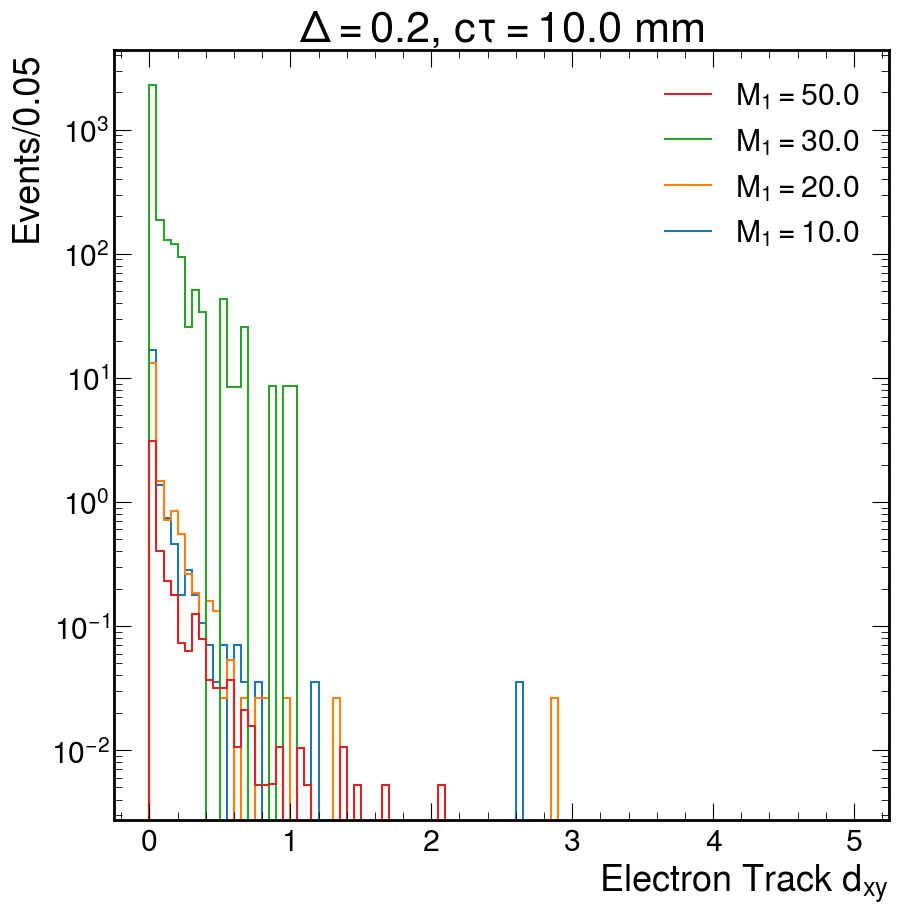

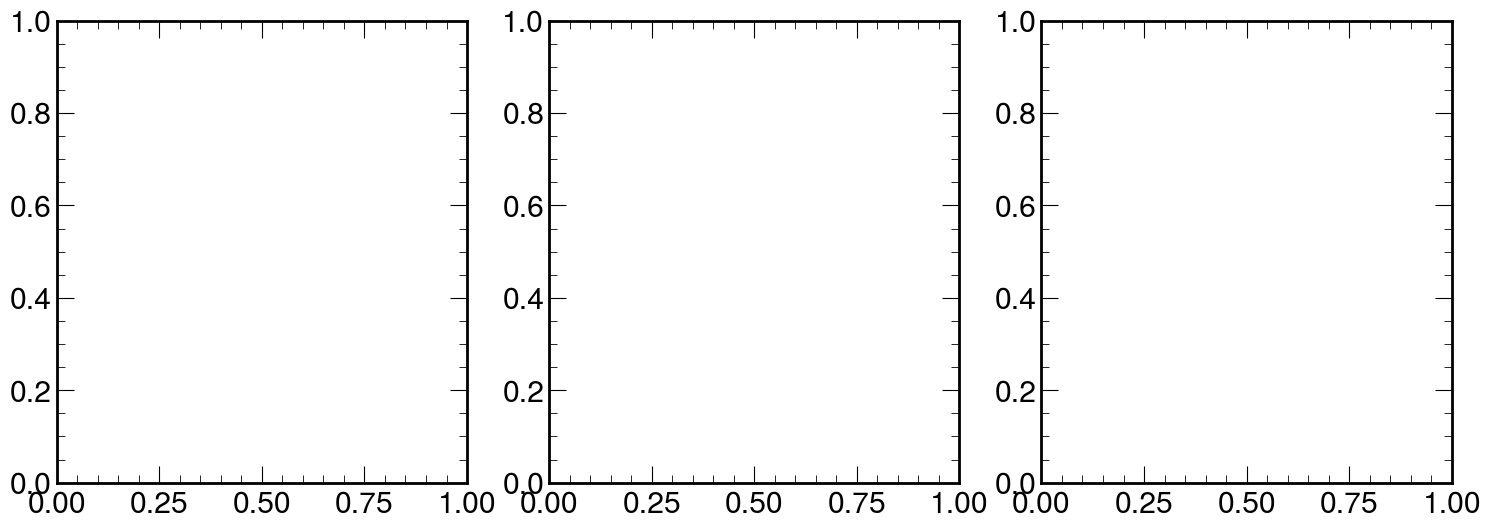

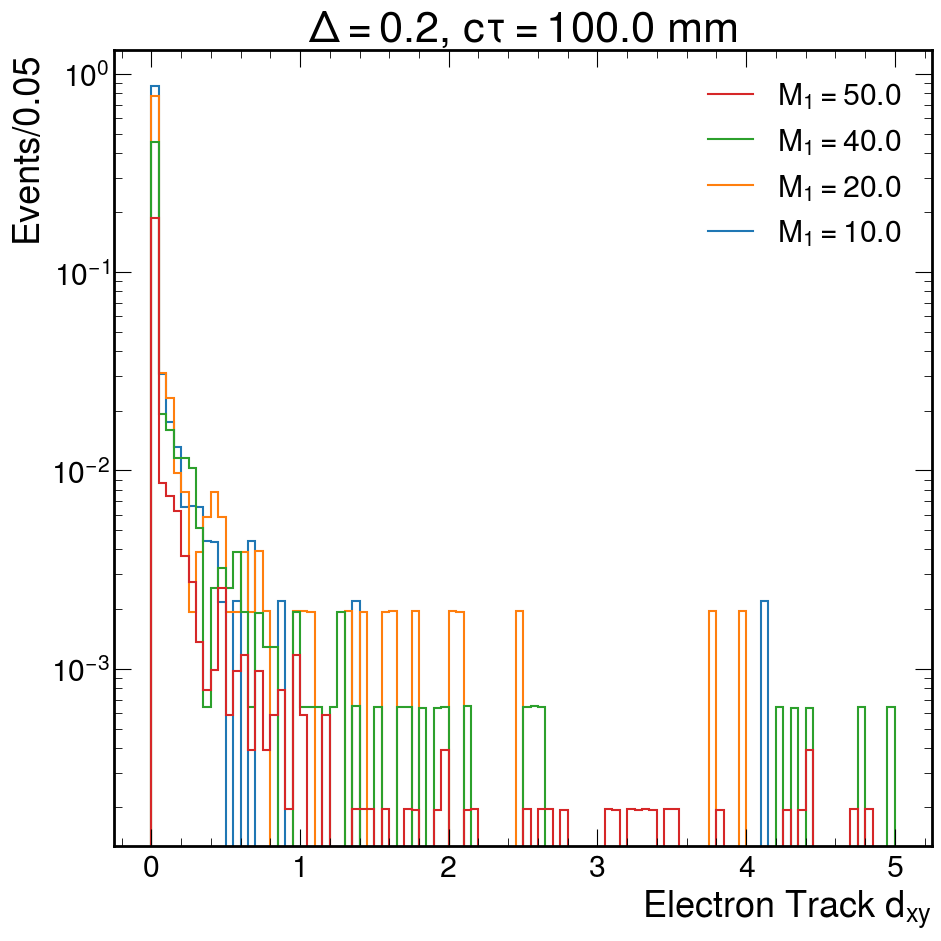

In [154]:
for delta in deltas:
    ctaus = sorted(list(set(si[si.delta==delta].ctau)))
    
    fig,axes = plt.subplots(1,len(ctaus),figsize=(6*len(ctaus),6))
    
    for i, ct in enumerate(ctaus):
        plt.sca(axes[i])
        plot_sig_varying_M1( 'sel_vtx_minDxy', 'nocut', delta, ct, rebin=5j )
        #plt.savefig(f'plots/cutflow/efficiency_delta_{delta}.png')
    plt.tight_layout()
    plt.show()

In [155]:
def plot_bkg_sig_varying_M1(hname, cut, delta, ct, rebin=1j, xlim = [], flow_str=None, doLog=True, doSave=False, outDir = 'plots/', outName='plot.png'):    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # bkg
    # sort the histograms by the entries
    for b in bkg_histos.keys():
        entries = {b: bkg[hname][b].sum().value for b in bkg_histos.keys()}
    
    sorted_entries = dict(sorted(entries.items(), key=lambda x:x[1], reverse = True))

    bkg_stack = {b:bkg[hname][b] for b in sorted_entries.keys()}
    avail_cuts = {b:[bkg_stack[b].axes[0].bin(i) for i in range(len(bkg_stack[b].axes[0].widths))] for b in bkg_stack.keys()}
    bkg_stack = {b:bkg_stack[b][cut,::rebin] for b in bkg_stack.keys() if cut in avail_cuts[b]}
    
    hb = hist.Stack.from_dict(bkg_stack)

    binwidth = hb['W+jets'].axes.widths[0][0]
    
    hb[::-1].plot(stack = True, yerr=False, density=False, histtype='fill', color=[k for k in mpl.colormaps['Set3'].colors][:nb])

    # signal
    m1_list = sorted(list(set(si[(si.delta==delta) & (si.ctau==ct)].m1)))
    
    for j, m1 in enumerate(m1_list): 
        point = si[(si.delta==delta) & (si.m1==m1) & (si.ctau==ct)].name[0]
        hs = sig_histo[hname][{"samp":point,"cut":cut}][::rebin]
        mplhep.histplot(hs,label=r"$M_1 = {0}$".format(m1),yerr=False,density=False,color=f"C{j}",ax=plt.gca(),flow=flow_str)
    
    binwidth = hs.axes.widths[0][0]

    #plt.title(r"$\Delta = {0:.1f}$, $c\tau = {1}$ mm".format(delta,ct))
    plt.ylabel(f'Events/{binwidth}')
    if doLog:
        plt.yscale('log')
    plt.legend()
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='upper right')

    if xlim != []:
        plt.xlim(xlim)
    
    if doSave:
        if not os.path.isdir(outDir):
            os.makedirs(outDir)
        plt.savefig(f'{outDir}/{outName}')
        print(f'Saved: {outDir}/{outName}')

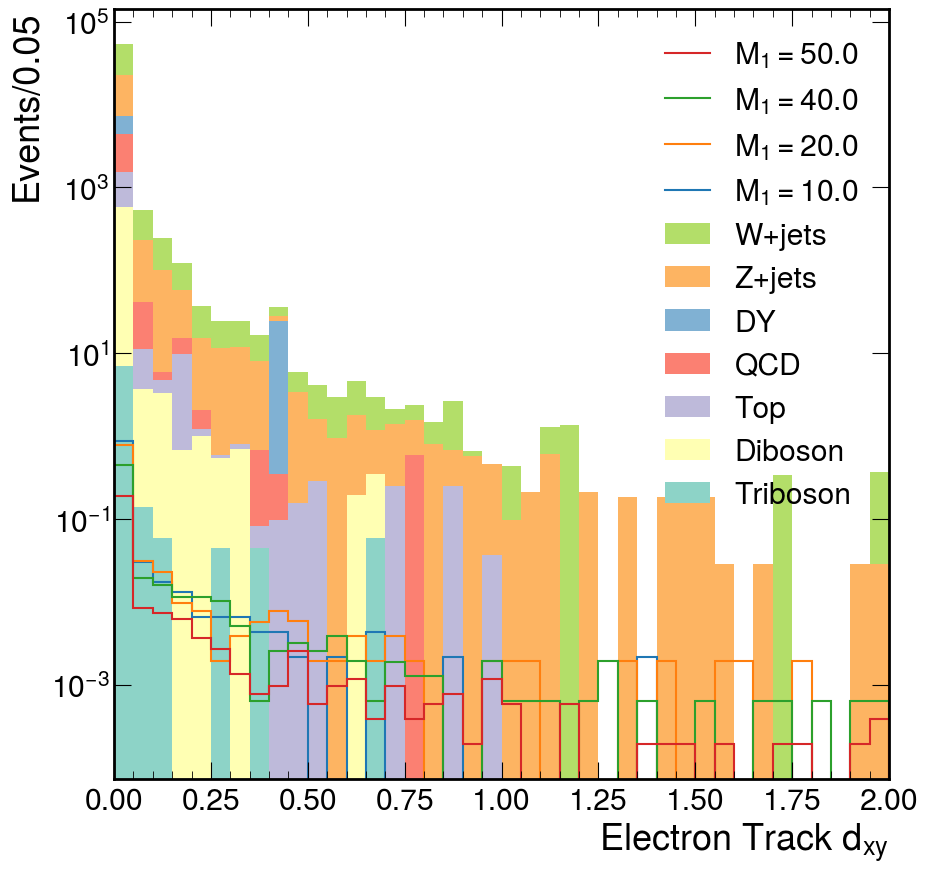

In [163]:
plot_bkg_sig_varying_M1('sel_vtx_minDxy', 'nocut', delta, ct, rebin=5j, xlim=[0,2], doLog=True)